# Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import norm, zscore
import statsmodels.api as sm

# Load and Format

In [2]:
df = pd.read_csv('data.csv')
df

,No.,วันที่,ช่วงเวลา,02t,03t,11t,12t,50t,52t,53t,...,bkp85t,19t,o63,bkp90t,bkp88t,bkp86t,bkp94t,bkp84t,bkp83t,bkp63t
0,1,2025-01-19,01:00,55.5,51.7,47.1,44.2,50.1,54.5,49.9,...,62.1,55.7,54.1,50.1,66.9,65.2,48.2,52.7,51.0,49.6
1,2,2025-01-19,02:00,60.3,56.6,48.1,48.1,54.0,60.7,55.5,...,63.8,45.9,55.0,52.6,63.1,64.1,51.5,55.2,52.0,54.7
2,3,2025-01-19,03:00,57.9,58.1,46.2,45.8,55.3,56.0,56.7,...,69.8,40.5,47.3,54.4,68.0,78.9,56.4,58.8,49.0,56.9
3,4,2025-01-19,04:00,55.2,55.3,40.3,43.1,48.6,55.1,45.5,...,77.6,43.4,45.2,53.2,69.1,73.7,50.8,60.2,45.0,56.1
4,5,2025-01-19,05:00,60.7,60.3,40.9,44.5,47.9,58.4,45.1,...,92.0,50.8,53.1,70.5,72.0,74.6,49.1,76.5,41.0,48.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
729,730,2025-02-18,10:00,25.5,27.2,24.9,24.9,28.7,25.0,29.9,...,26.3,24.3,24.9,27.1,21.0,20.2,17.1,52.6,25.0,21.9
730,731,2025-02-18,11:00,28.1,26.7,21.1,21.9,25.4,27.5,24.2,...,27.4,23.5,22.5,19.8,28.8,16.6,17.0,22.2,18.0,29.5
731,732,2025-02-18,12:00,NaN,24.3,20.2,20.9,25.0,25.1,24.3,...,26.5,23.7,20.6,NaN,25.1,35.4,16.1,22.1,20.0,28.1
732,733,2025-02-18,13:00,NaN,NaN,19.7,19.2,22.8,27.9,22.9,...,39.4,21.8,19.7,32.6,35.8,25.2,25.7,21.0,24.0,34.5


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 734 entries, 0 to 733
Data columns (total 95 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   No.       734 non-null    int64  
 1   วันที่    734 non-null    object 
 2   ช่วงเวลา  734 non-null    object 
 3   02t       731 non-null    float64
 4   03t       732 non-null    float64
 5   11t       734 non-null    float64
 6   12t       734 non-null    float64
 7   50t       733 non-null    float64
 8   52t       730 non-null    float64
 9   53t       734 non-null    float64
 10  54t       734 non-null    float64
 11  59t       734 non-null    float64
 12  61t       727 non-null    float64
 13  bkp100t   734 non-null    float64
 14  bkp101t   734 non-null    float64
 15  bkp102t   732 non-null    float64
 16  bkp103t   726 non-null    float64
 17  bkp104t   733 non-null    float64
 18  bkp105t   730 non-null    float64
 19  bkp112t   733 non-null    float64
 20  bkp114t   732 non-null    float6

In [4]:
df['datetime'] = pd.to_datetime(df['วันที่'] + ' ' + df['ช่วงเวลา'])
df = df.set_index('datetime')
df = df.drop(columns=["No.", "วันที่", "ช่วงเวลา"])
df

,02t,03t,11t,12t,50t,52t,53t,54t,59t,61t,...,bkp85t,19t,o63,bkp90t,bkp88t,bkp86t,bkp94t,bkp84t,bkp83t,bkp63t
datetime,,,,,,,,,,,,,,,,,,,,,
2025-01-19 01:00:00,55.5,51.7,47.1,44.2,50.1,54.5,49.9,44.9,36.9,41.1,...,62.1,55.7,54.1,50.1,66.9,65.2,48.2,52.7,51.0,49.6
2025-01-19 02:00:00,60.3,56.6,48.1,48.1,54.0,60.7,55.5,55.1,37.4,47.4,...,63.8,45.9,55.0,52.6,63.1,64.1,51.5,55.2,52.0,54.7
2025-01-19 03:00:00,57.9,58.1,46.2,45.8,55.3,56.0,56.7,46.8,40.9,44.9,...,69.8,40.5,47.3,54.4,68.0,78.9,56.4,58.8,49.0,56.9
2025-01-19 04:00:00,55.2,55.3,40.3,43.1,48.6,55.1,45.5,40.5,45.2,40.1,...,77.6,43.4,45.2,53.2,69.1,73.7,50.8,60.2,45.0,56.1
2025-01-19 05:00:00,60.7,60.3,40.9,44.5,47.9,58.4,45.1,41.4,47.2,41.1,...,92.0,50.8,53.1,70.5,72.0,74.6,49.1,76.5,41.0,48.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-18 10:00:00,25.5,27.2,24.9,24.9,28.7,25.0,29.9,28.7,14.0,24.2,...,26.3,24.3,24.9,27.1,21.0,20.2,17.1,52.6,25.0,21.9
2025-02-18 11:00:00,28.1,26.7,21.1,21.9,25.4,27.5,24.2,27.3,14.9,21.0,...,27.4,23.5,22.5,19.8,28.8,16.6,17.0,22.2,18.0,29.5
2025-02-18 12:00:00,NaN,24.3,20.2,20.9,25.0,25.1,24.3,24.1,15.2,20.9,...,26.5,23.7,20.6,NaN,25.1,35.4,16.1,22.1,20.0,28.1


# EDA

In [5]:
df.describe()

,02t,03t,11t,12t,50t,52t,53t,54t,59t,61t,...,bkp85t,19t,o63,bkp90t,bkp88t,bkp86t,bkp94t,bkp84t,bkp83t,bkp63t
count,731.000000,732.000000,734.000000,734.000000,733.000000,730.000000,734.000000,734.000000,734.000000,727.000000,...,732.000000,729.000000,733.000000,731.000000,732.000000,734.000000,734.000000,733.000000,730.000000,732.000000
mean,49.652804,49.651639,42.123161,42.178065,47.274352,49.191781,46.574659,49.674114,35.867847,41.644704,...,55.073361,42.465981,43.321010,45.394802,55.671858,48.058174,54.107493,48.540791,45.383699,48.592213
std,18.691237,19.997426,15.057354,15.174247,17.136868,18.875035,17.611950,17.455395,13.119240,14.913804,...,21.317001,18.515011,16.089138,21.847879,53.049562,22.921667,71.853561,20.212515,18.725374,17.985667
min,13.400000,12.900000,10.200000,10.500000,14.700000,13.400000,13.100000,13.800000,7.200000,10.600000,...,4.600000,16.800000,11.200000,4.600000,12.200000,7.500000,10.700000,5.200000,8.000000,14.000000
25%,36.650000,35.575000,30.825000,31.200000,35.100000,36.200000,33.900000,37.225000,25.625000,30.400000,...,40.775000,31.600000,31.500000,31.500000,37.900000,31.925000,35.100000,35.100000,33.000000,36.100000
50%,44.900000,45.500000,39.900000,39.800000,44.300000,44.200000,43.550000,47.500000,35.300000,39.700000,...,49.400000,37.900000,40.200000,40.600000,47.950000,43.200000,45.550000,44.000000,42.000000,46.100000
75%,60.750000,60.150000,50.800000,50.900000,56.400000,60.000000,55.800000,59.675000,45.100000,50.450000,...,64.725000,47.300000,54.100000,54.600000,64.300000,58.600000,59.600000,57.700000,56.000000,57.900000
max,122.300000,117.300000,94.700000,91.700000,121.500000,117.000000,117.300000,112.500000,75.800000,93.300000,...,144.000000,190.000000,98.000000,145.600000,983.700000,143.400000,985.000000,127.100000,121.900000,125.400000


## handle NaN

In [6]:
df.isna().sum().sum()

302

In [7]:
while True:
    nan = df.isna().sum().sum()
    print(f"NaN count: {nan}")
    if nan == 0:
        break
    # use median to be more robust against outliers
    df.fillna(df.rolling(window=24, min_periods=1).median(), inplace=True) 

NaN count: 302
NaN count: 18
NaN count: 0


## handle outliers

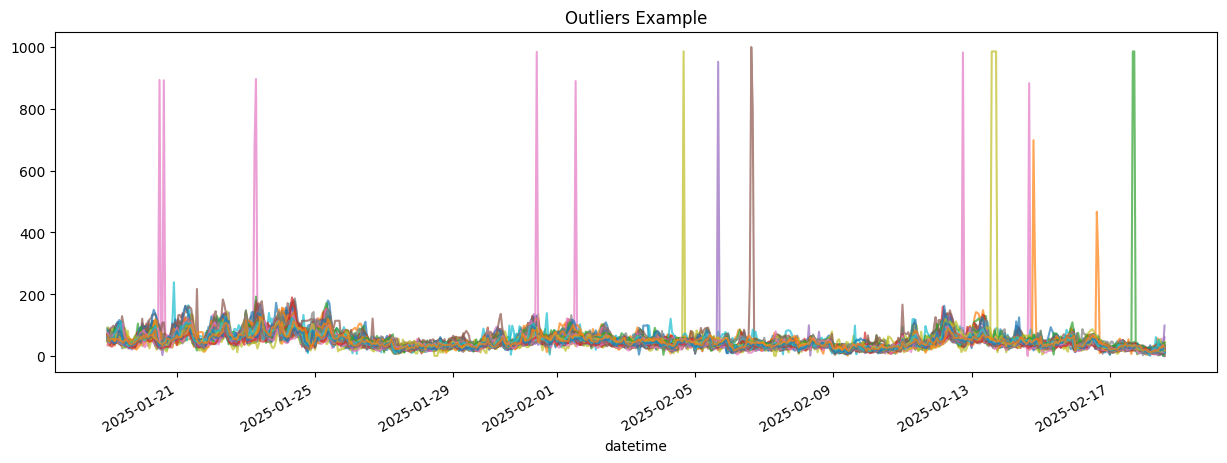

In [8]:
# some sensors' readings are outliers
df.plot(figsize=(15,5), alpha=0.7)
plt.title("Outliers Example")
plt.legend([], [], frameon=False)
plt.show()

In [9]:
z_scores = np.abs(df.apply(zscore))
z_scores.describe()

,02t,03t,11t,12t,50t,52t,53t,54t,59t,61t,...,bkp85t,19t,o63,bkp90t,bkp88t,bkp86t,bkp94t,bkp84t,bkp83t,bkp63t
count,734.000000,734.000000,734.000000,734.000000,734.000000,734.000000,734.000000,734.000000,734.000000,734.000000,...,734.000000,734.000000,734.000000,734.000000,734.000000,734.000000,734.000000,734.000000,734.000000,734.000000
mean,0.792736,0.779348,0.796366,0.795922,0.772048,0.789500,0.777530,0.779109,0.812352,0.794526,...,0.775500,0.661578,0.815912,0.748500,0.376057,0.767334,0.304831,0.761548,0.773735,0.765310
std,0.609981,0.627018,0.605228,0.605813,0.635998,0.614169,0.629274,0.627316,0.583564,0.607644,...,0.631778,0.750387,0.578570,0.663587,0.927228,0.641685,0.953056,0.648551,0.633941,0.644100
min,0.001013,0.000811,0.005107,0.001447,0.002497,0.000679,0.001440,0.007217,0.002452,0.002966,...,0.001805,0.000303,0.000627,0.003677,0.001459,0.001826,0.000104,0.000465,0.017382,0.000645
25%,0.368227,0.324211,0.333829,0.328284,0.325571,0.375578,0.329527,0.297363,0.340789,0.319799,...,0.316586,0.254653,0.384724,0.301963,0.158212,0.304148,0.103301,0.291414,0.344116,0.323782
50%,0.662550,0.635042,0.669687,0.674096,0.641967,0.643876,0.639206,0.627741,0.734701,0.677077,...,0.612575,0.498766,0.720352,0.579630,0.289469,0.643935,0.210293,0.612952,0.620016,0.615632
75%,1.044013,1.088416,1.107418,1.113042,1.053620,1.049959,1.072466,1.121453,1.145365,1.108508,...,1.058548,0.828417,1.181227,1.008958,0.444248,1.050120,0.330167,0.998055,1.040434,1.019875
max,3.891421,3.386032,3.494152,3.265777,4.333698,3.593668,4.018497,3.601679,3.045861,3.482187,...,4.179620,7.996220,3.400415,4.594900,17.527570,4.162299,12.964246,3.880849,4.096248,4.279424


In [10]:
df[z_scores > 3.75] = np.nan
while True:
    nan = df.isna().sum().sum()
    print(f"NaN count: {nan}")
    if nan == 0:
        break
    # use mean as there are no outliers
    df.fillna(df.rolling(window=24, min_periods=1).mean(), inplace=True) 

NaN count: 193
NaN count: 0


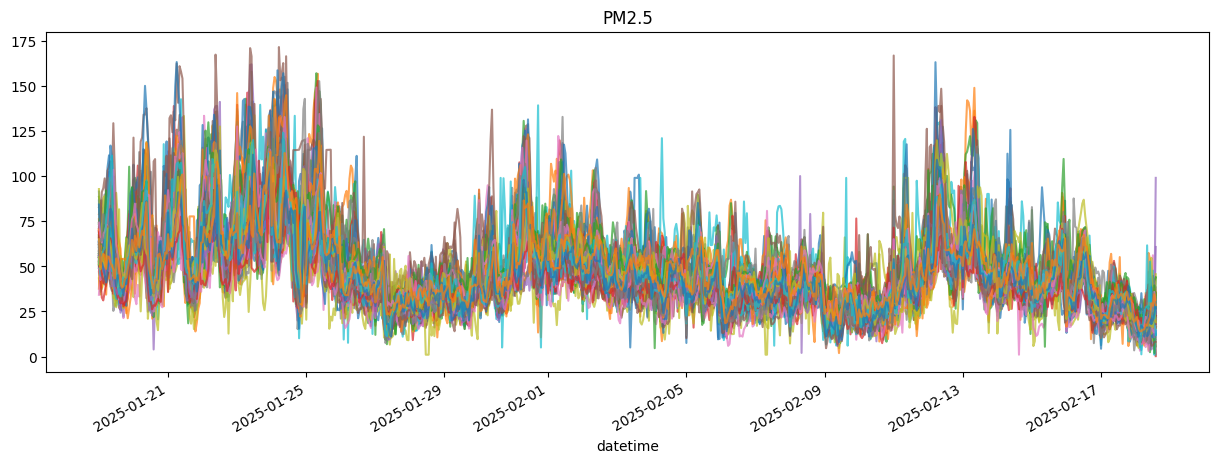

In [11]:
df.plot(figsize=(15,5), alpha=0.7)
plt.title("PM2.5")
plt.legend([], [], frameon=False)
plt.show()

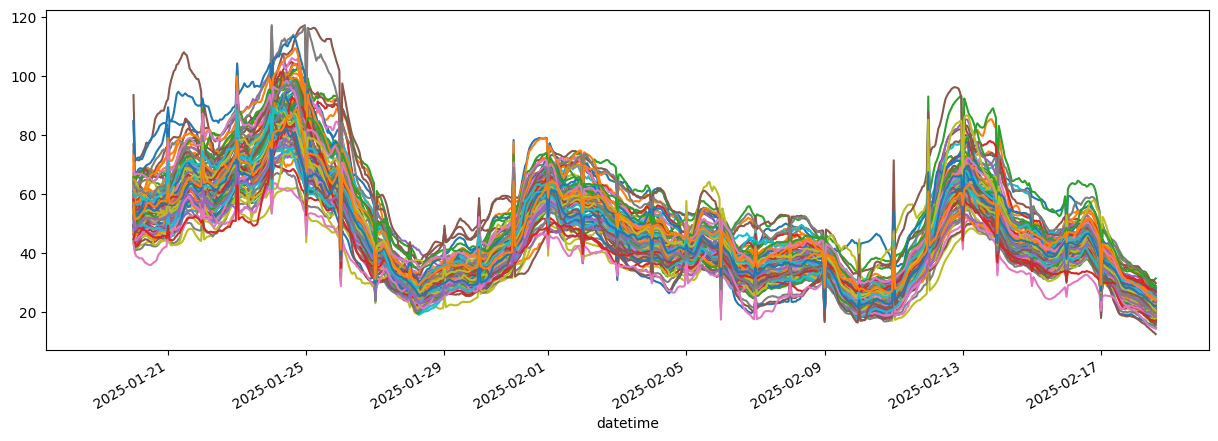

In [12]:
df.rolling(window=24).mean().plot(figsize=(15,5))
plt.legend([], [], frameon=False)

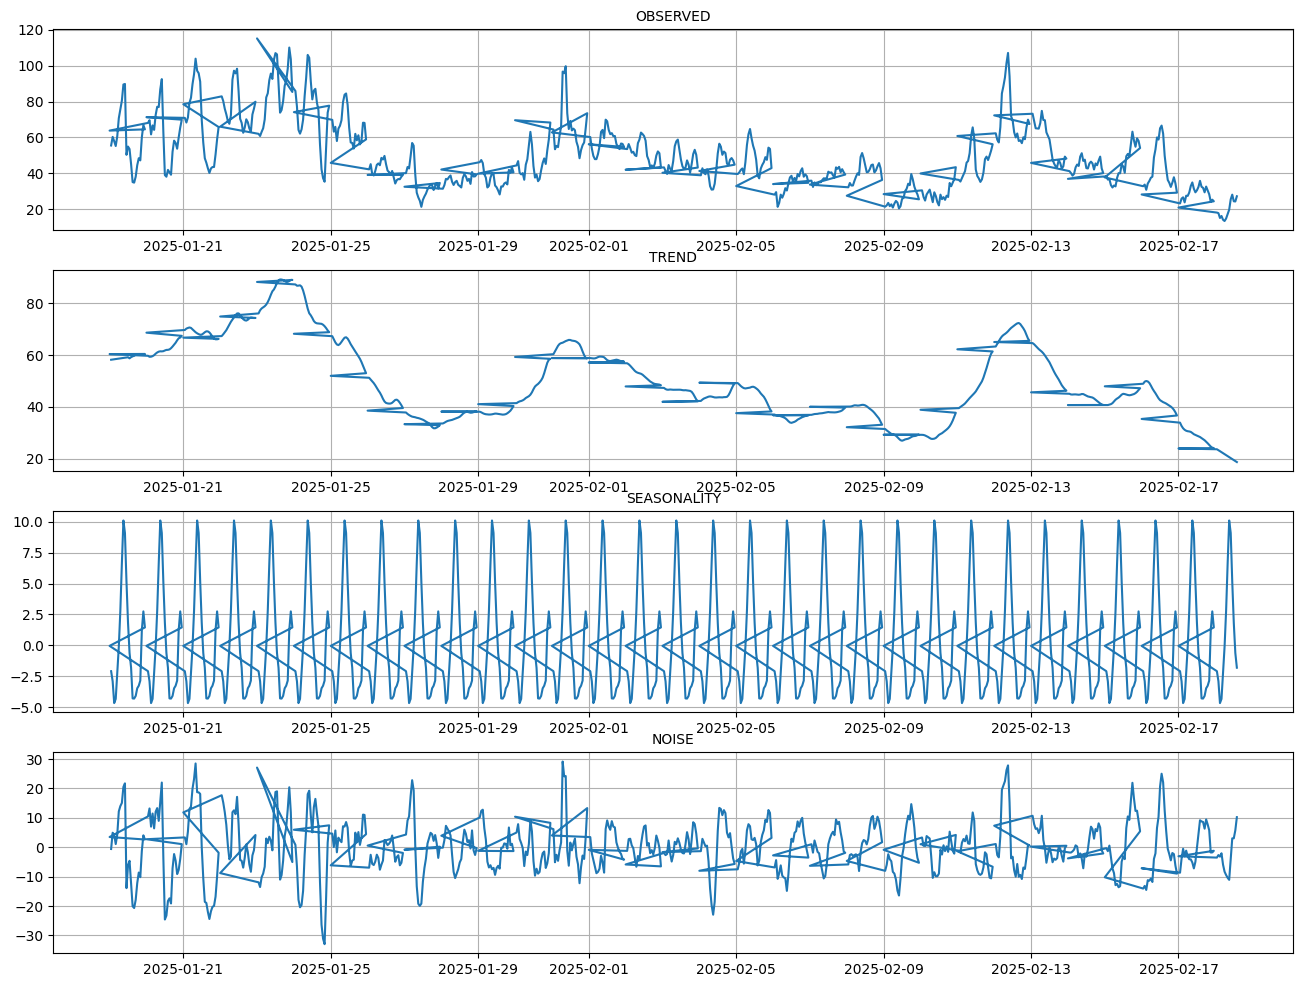

In [13]:
res=sm.tsa.seasonal_decompose(df.iloc[:, 0],model='additive',extrapolate_trend ='freq',period=24)
fig, axs = plt.subplots(4, figsize=(16,12))
axs[0].set_title('OBSERVED', fontsize=10)
axs[0].plot(res.observed)
axs[0].grid()

axs[1].set_title('TREND', fontsize=10)
axs[1].plot(res.trend)
axs[1].grid()

axs[2].set_title('SEASONALITY', fontsize=10)
axs[2].plot(res.seasonal)
axs[2].grid()

axs[3].set_title('NOISE', fontsize=10)
axs[3].plot(res.resid)
axs[3].grid()

plt.legend([], [], frameon=False)
plt.show()

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

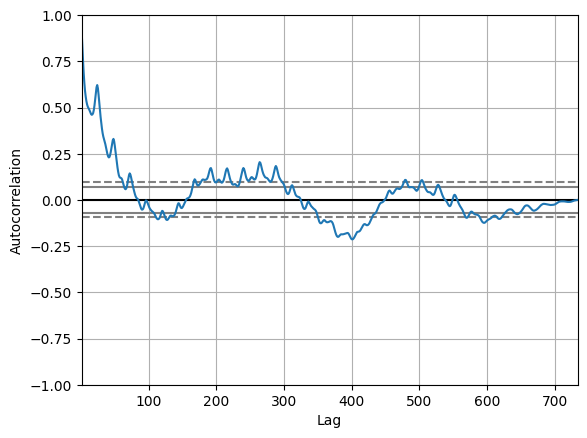

In [14]:
pd.plotting.autocorrelation_plot(df)

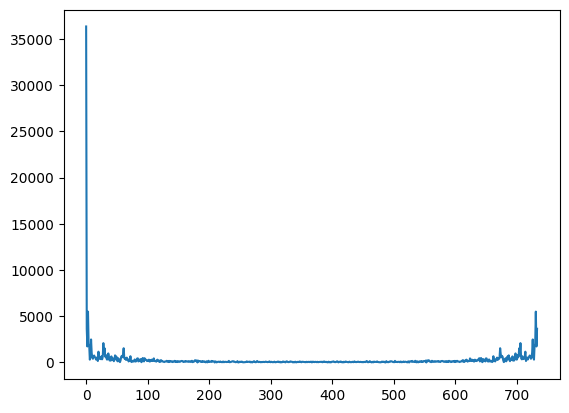

In [15]:
freq_spectrum = np.fft.fft(df.iloc[:, 0].dropna())
plt.plot(np.abs(freq_spectrum))
plt.show()

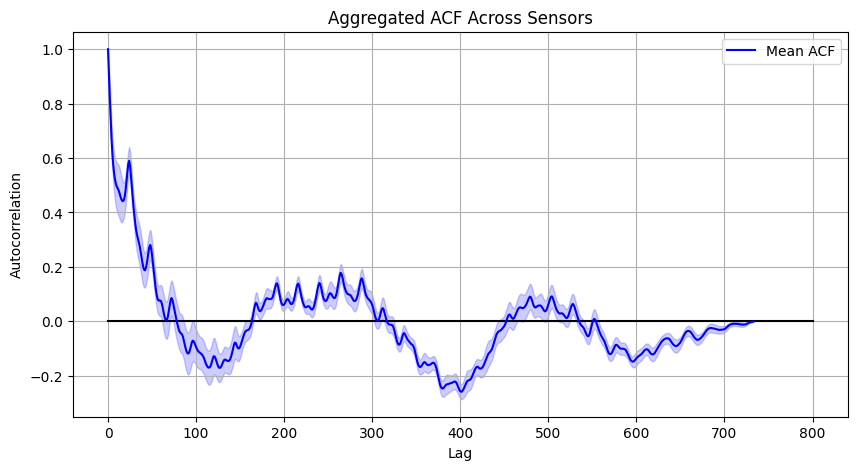

In [16]:
max_lag = 800
acf_values = []

# Compute ACF for each column
for col in df.columns:
    acf_result = sm.tsa.stattools.acf(df[col].dropna(), nlags=max_lag, fft=True)  # ACF
    acf_values.append(acf_result)

# Convert to DataFrame and compute mean across all sensors
acf_matrix = np.array(acf_values)  # Shape: (num_sensors, max_lag+1)
mean_acf = np.mean(acf_matrix, axis=0)
std_acf = np.std(acf_matrix, axis=0)

# Plot the aggregated ACF
plt.figure(figsize=(10, 5))
plt.plot(np.zeros(max_lag+1), color="black") 
plt.plot(range(len(mean_acf)), mean_acf, label="Mean ACF", color='b')
plt.fill_between(range(len(mean_acf)), mean_acf - std_acf, mean_acf + std_acf, color='b', alpha=0.2)
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.title("Aggregated ACF Across Sensors")
plt.legend()
plt.grid()
plt.show()


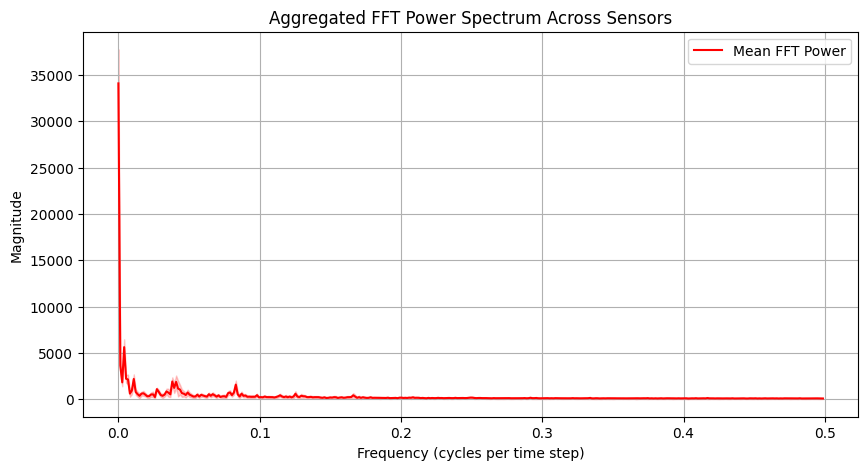

In [17]:
# Define variables
n = len(df)  # Number of time steps
freqs = np.fft.fftfreq(n)  # Frequency axis
fft_values = []

# Compute FFT for each sensor
for col in df.columns:
    fft_result = np.fft.fft(df[col].dropna())
    fft_values.append(np.abs(fft_result))  # Store magnitude of FFT

# Convert to array and compute mean power spectrum
fft_matrix = np.array(fft_values)  # Shape: (num_sensors, n)
mean_fft = np.mean(fft_matrix, axis=0)
std_fft = np.std(fft_matrix, axis=0)

# Plot the aggregated FFT spectrum (Only positive frequencies)
plt.figure(figsize=(10, 5))
plt.plot(freqs[:n//2], mean_fft[:n//2], label="Mean FFT Power", color='r')
plt.fill_between(freqs[:n//2], mean_fft[:n//2] - std_fft[:n//2], mean_fft[:n//2] + std_fft[:n//2], color='r', alpha=0.2)
plt.xlabel("Frequency (cycles per time step)")
plt.ylabel("Magnitude")
plt.title("Aggregated FFT Power Spectrum Across Sensors")
plt.legend()
plt.grid()
plt.show()


### Interpretation

Obviously, there is a large autocorrelation in small lags. Furtehrmore, there seems to be some seasonal elements at around 1.1 and 2.5 hour cycle, however, they are very small and are likely neglectible.

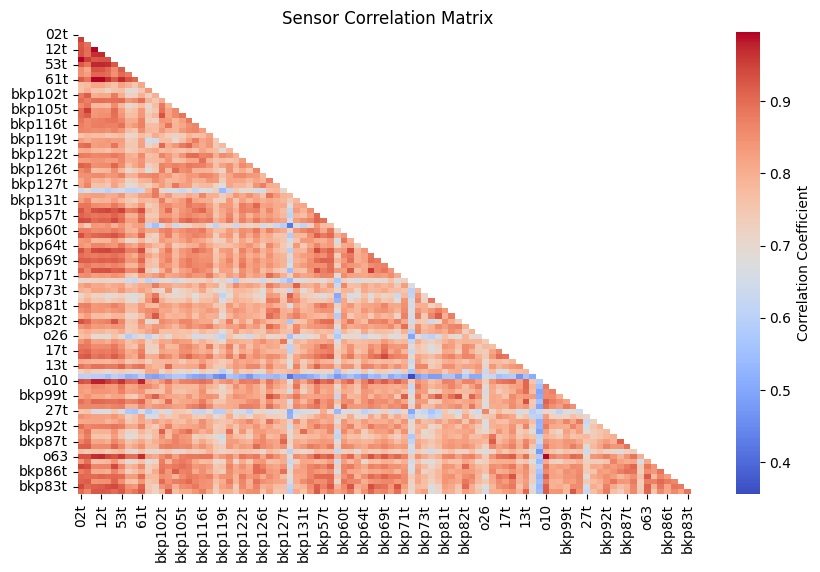

In [18]:
# Compute the correlation matrix
corr_matrix = df.corr()

# Mask the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", mask=mask, fmt=".2f", cbar_kws={'label': 'Correlation Coefficient'})
plt.title("Sensor Correlation Matrix")
plt.show()


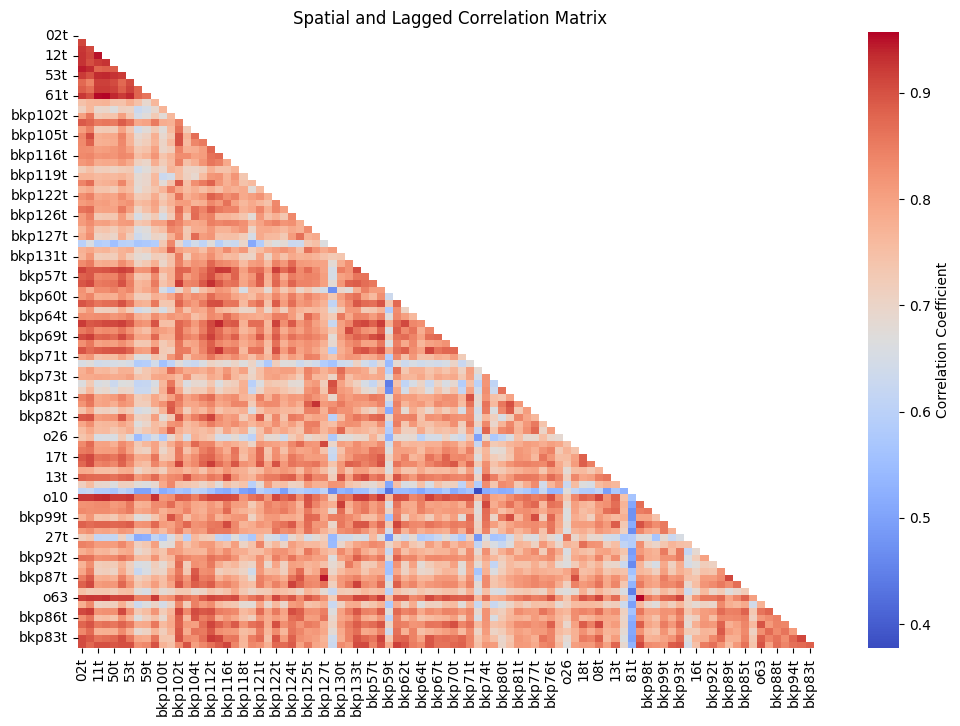

In [26]:
lag = 1

# Shift the data by lag (you can shift by more than 1 if needed)
df_lagged = df.shift(lag)

# Initialize an empty DataFrame to store correlations
lagged_corr_matrix = pd.DataFrame(index=df.columns, columns=df.columns)

# Calculate the correlation between original and lagged readings for each pair of stations
for station1 in df.columns:
    for station2 in df.columns:
        # Drop any NaN values from both series (for matching indices)
        corr_value = df[station1].dropna().corr(df_lagged[station2].dropna())
        lagged_corr_matrix.loc[station1, station2] = corr_value

# Mask the upper triangle
mask = np.triu(np.ones_like(lagged_corr_matrix, dtype=bool))

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(lagged_corr_matrix.astype(float), annot=False, cmap="coolwarm", mask=mask, fmt=".2f", cbar_kws={'label': 'Correlation Coefficient'})
plt.title("Spatial and Lagged Correlation Matrix")
plt.show()

There are many stations that shows correlation only with lag. This is likely due to it being up or down wind from the other stations. For example o63 which is in บางนา.